Loading and processing data...
Processed: 10n_gateway_results_1000mbs/result_ior_32_ts100m_bs1000m_t1/32_ts100m_bs1000m_t1.json -> bs:1000m, ts:100m, write:678.2481, read:1104.0447
Processed: 10n_gateway_results_1000mbs/result_ior_32_ts100m_bs1000m_t2/32_ts100m_bs1000m_t2.json -> bs:1000m, ts:100m, write:657.7424, read:1113.3678
Processed: 10n_gateway_results_1000mbs/result_ior_32_ts100m_bs1000m_t3/32_ts100m_bs1000m_t3.json -> bs:1000m, ts:100m, write:657.9459, read:1108.2078
Processed: 10n_gateway_results_100mbs/10n_result_ior_32_ts100m_bs100m_t1/32_ts100m_bs100m_t1.json -> bs:100m, ts:100m, write:1117.8202, read:1112.3646
Processed: 10n_gateway_results_100mbs/10n_result_ior_32_ts100m_bs100m_t2/32_ts100m_bs100m_t2.json -> bs:100m, ts:100m, write:1118.0733, read:1104.1502
Processed: 10n_gateway_results_100mbs/10n_result_ior_32_ts100m_bs100m_t3/32_ts100m_bs100m_t3.json -> bs:100m, ts:100m, write:1117.0962, read:1111.3093
Processed: 10n_gateway_results_10mbs/10n_result_ior_32_ts10m_bs10m

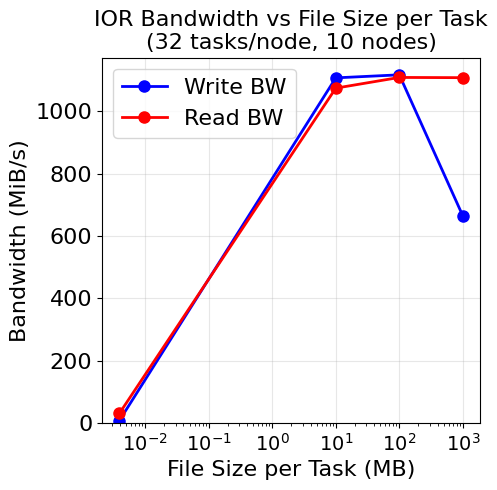


Summary of processed data:
File Size per Task Block Size Max Transfer Size Write BW (MiB/s) Read BW (MiB/s)
--------------------------------------------------------------------------------
4.00 KB            4k         4k              7.0             30.0           
10.00 MB           10m        10m             1107.9          1074.9         
100.00 MB          100m       100m            1117.7          1109.3         
1000.00 MB         1000m      100m            664.6           1108.5         


In [5]:
import os
import json
import matplotlib.pyplot as plt
import re
from collections import defaultdict

# Constants
TASKS_PER_NODE = 32
NUM_NODES = 10
TOTAL_TASKS = TASKS_PER_NODE * NUM_NODES

def parse_size(size_str):
    """Parse size string and return size in bytes"""
    # Extract number and unit from strings like '100m', '4k', '1000m', '10m'
    match = re.match(r'(\d+)([kmgt]?)', size_str.lower())
    if not match:
        return 0
    
    number = int(match.group(1))
    unit = match.group(2)
    
    multipliers = {
        '': 1,
        'k': 1024,
        'm': 1024**2,
        'g': 1024**3,
        't': 1024**4
    }
    
    return number * multipliers.get(unit, 1)

def format_size(size_bytes):
    """Format size in bytes to human readable format"""
    if size_bytes >= 1024**4:
        return f"{size_bytes / (1024**4):.2f} TB"
    elif size_bytes >= 1024**3:
        return f"{size_bytes / (1024**3):.2f} GB"
    elif size_bytes >= 1024**2:
        return f"{size_bytes / (1024**2):.2f} MB"
    elif size_bytes >= 1024:
        return f"{size_bytes / 1024:.2f} KB"
    else:
        return f"{size_bytes} B"

def extract_test_info(filepath):
    """Extract test information from filepath"""
    # Extract block size from folder name like '10n_gateway_results_1000bs' or '10n_gateway_results_4kbs'
    parts = filepath.split('/')
    if len(parts) >= 2:
        folder_name = parts[0]  # e.g., '10n_gateway_results_1000bs'
        file_name = parts[-1]   # e.g., '32_ts100m_bs1000m_t1.json'
        
        # Extract block size from folder name
        if folder_name.endswith('bs'):
            # Handle cases like '1000bs', '100mbs', '10mbs', '4kbs'
            bs_match = re.search(r'_([0-9]+[kmgt]?)bs$', folder_name)
            if bs_match:
                block_size_str = bs_match.group(1)
            else:
                return None, None, None
        else:
            return None, None, None
        
        # Extract transfer size from file name
        ts_match = re.search(r'_ts([0-9]+[kmgt]?)_', file_name)
        if not ts_match:
            return None, None, None
            
        transfer_size_str = ts_match.group(1)
        
        return block_size_str, transfer_size_str, filepath
    
    return None, None, None

# Specific file list based on your ls output
specific_files = [
    "10n_gateway_results_1000mbs/result_ior_32_ts100m_bs1000m_t1/32_ts100m_bs1000m_t1.json",
    "10n_gateway_results_1000mbs/result_ior_32_ts100m_bs1000m_t2/32_ts100m_bs1000m_t2.json", 
    "10n_gateway_results_1000mbs/result_ior_32_ts100m_bs1000m_t3/32_ts100m_bs1000m_t3.json",
    "10n_gateway_results_100mbs/10n_result_ior_32_ts100m_bs100m_t1/32_ts100m_bs100m_t1.json",
    "10n_gateway_results_100mbs/10n_result_ior_32_ts100m_bs100m_t2/32_ts100m_bs100m_t2.json",
    "10n_gateway_results_100mbs/10n_result_ior_32_ts100m_bs100m_t3/32_ts100m_bs100m_t3.json",
    "10n_gateway_results_10mbs/10n_result_ior_32_ts10m_bs10m_t1/32_ts10m_bs10m_t1.json",
    "10n_gateway_results_10mbs/10n_result_ior_32_ts10m_bs10m_t2/32_ts10m_bs10m_t2.json",
    "10n_gateway_results_10mbs/10n_result_ior_32_ts10m_bs10m_t3/32_ts10m_bs10m_t3.json",
    "10n_gateway_results_4kbs/10n_result_ior_32_ts4k_bs4k_t1/32_ts4k_bs4k_t1.json",
    "10n_gateway_results_4kbs/10n_result_ior_32_ts4k_bs4k_t2/32_ts4k_bs4k_t2.json",
    "10n_gateway_results_4kbs/10n_result_ior_32_ts4k_bs4k_t3/32_ts4k_bs4k_t3.json"
]

def load_and_process_data():
    """Load specific JSON files and process the data"""
    data = defaultdict(lambda: defaultdict(list))  # data[block_size][transfer_size] = [(write_bw, read_bw), ...]
    
    for json_file in specific_files:
        if not os.path.exists(json_file):
            print(f"File not found: {json_file}")
            continue
            
        block_size_str, transfer_size_str, filepath = extract_test_info(json_file)
        if not block_size_str or not transfer_size_str:
            print(f"Could not parse: {json_file}")
            continue
        
        try:
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                
            if 'summary' not in json_data:
                print(f"No summary found in: {json_file}")
                continue
                
            write_bw = None
            read_bw = None
            
            for entry in json_data['summary']:
                if entry.get('operation') == 'write':
                    write_bw = entry.get('bwMeanMIB')
                elif entry.get('operation') == 'read':
                    read_bw = entry.get('bwMeanMIB')
            
            if write_bw is not None or read_bw is not None:
                data[block_size_str][transfer_size_str].append((write_bw, read_bw))
                print(f"Processed: {json_file} -> bs:{block_size_str}, ts:{transfer_size_str}, write:{write_bw}, read:{read_bw}")
                
        except Exception as e:
            print(f"Error processing {json_file}: {e}")
    
    return data

def get_max_transfer_size_data(transfer_size_data):
    """Get data for the largest transfer size"""
    if not transfer_size_data:
        return None, None, None
    
    # Find the largest transfer size
    max_ts = max(transfer_size_data.keys(), key=lambda x: parse_size(x))
    
    # Average the bandwidth values for this transfer size
    write_bws = [bw[0] for bw in transfer_size_data[max_ts] if bw[0] is not None]
    read_bws = [bw[1] for bw in transfer_size_data[max_ts] if bw[1] is not None]
    
    avg_write_bw = sum(write_bws) / len(write_bws) if write_bws else None
    avg_read_bw = sum(read_bws) / len(read_bws) if read_bws else None
    
    return avg_write_bw, avg_read_bw, max_ts

# Load and process all data
print("Loading and processing data...")
all_data = load_and_process_data()

print(f"\nFound data for {len(all_data)} different block sizes:")
for bs in all_data.keys():
    print(f"  Block size: {bs}")

# Prepare data for plotting
plot_data = []
for block_size_str, transfer_size_data in all_data.items():
    file_size_bytes = parse_size(block_size_str)  # File size per task (block size)
    write_bw, read_bw, max_ts = get_max_transfer_size_data(transfer_size_data)
    
    if write_bw is not None or read_bw is not None:
        plot_data.append({
            'file_size_bytes': file_size_bytes,
            'file_size_mb': file_size_bytes / (1024 * 1024),
            'file_size_str': format_size(file_size_bytes),
            'block_size': block_size_str,
            'max_transfer_size': max_ts,
            'write_bw': write_bw if write_bw is not None else 0,
            'read_bw': read_bw if read_bw is not None else 0
        })

# Sort by file size per task
plot_data.sort(key=lambda x: x['file_size_bytes'])

print(f"\nPlot data points: {len(plot_data)}")

if not plot_data:
    print("No data points found! Check file paths and data extraction.")
else:
    # Extract data for plotting (use MB for x-axis)
    file_sizes_mb = [d['file_size_mb'] for d in plot_data]
    write_bws = [d['write_bw'] for d in plot_data]
    read_bws = [d['read_bw'] for d in plot_data]

    # Create the plot
    plt.figure(figsize=(5, 5))
    plt.plot(file_sizes_mb, write_bws, 'bo-', label='Write BW', linewidth=2, markersize=8)
    plt.plot(file_sizes_mb, read_bws, 'ro-', label='Read BW', linewidth=2, markersize=8)

    # Set log scale for x-axis since file sizes vary greatly
    plt.xscale('log')

    plt.xlabel('File Size per Task (MB)', fontsize=16)
    plt.ylabel('Bandwidth (MiB/s)', fontsize=16)
    plt.title('IOR Bandwidth vs File Size per Task\n(32 tasks/node, 10 nodes)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=16)
    plt.ylim(bottom=0)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=16)

    plt.tight_layout()
    plt.savefig('ior_per_task_file.pdf', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary
    print("\nSummary of processed data:")
    print(f"{'File Size per Task':<18} {'Block Size':<10} {'Max Transfer Size':<15} {'Write BW (MiB/s)':<15} {'Read BW (MiB/s)':<15}")
    print("-" * 80)
    for d in plot_data:
        print(f"{d['file_size_str']:<18} {d['block_size']:<10} {d['max_transfer_size']:<15} {d['write_bw']:<15.1f} {d['read_bw']:<15.1f}")